In [4]:
import urllib.request
import zipfile

url = "ftp://cs.stanford.edu/cs/cvgl/Stanford_Online_Products.zip"
filename = "dataset.zip"

urllib.request.urlretrieve(url, filename)

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('.')

In [1]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import os
import torch
import base64
from glob import glob
import cv2
import supervision as sv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(torch.cuda.is_available())

False


In [3]:
# Enable flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    torch_dtype="auto",
    device_map="auto",
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the disk and cpu.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
# The default range for the number of visual tokens per image in the model is 4-16384.
# Set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

In [4]:
data_dir = "Stanford_Online_Products"
classes_dir = [d for d in glob(data_dir+"/*") if os.path.isdir(d)]

PER_CLASS_IMAGE_COUNT = 50
IMAGE_SIZE = (224, 224)

image_paths = [image for dir in classes_dir for image in glob(dir+"/*")[:PER_CLASS_IMAGE_COUNT]]
print(len(image_paths))

600


In [ ]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_paths[0],
            },
            {"type": "text", "text": "What is in the image?"},
        ],
    }
]

In [ ]:
# Preparation for inference

text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)

inputs = inputs.to("cuda")

In [ ]:
# Inference: Generation of the output

generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

In [5]:
def image_to_data_uri(image):
    ret, buffer = cv2.imencode('.jpg', image)
    encoded_image = base64.b64encode(buffer.tobytes()).decode("utf-8")

    return "data:image/jpeg;base64," + encoded_image

In [6]:
images = []
labels = []
train = []
image_data_uris = {}

for image_path in image_paths:
    image = cv2.imread(image_path)
    image = cv2.resize(image, IMAGE_SIZE)
    images.append(image)

    label = os.path.basename(os.path.dirname(image_path))
    labels.append(label)
    
    train.append(image.flatten())
    image_data_uris[image_path] = image_to_data_uri(image)

In [7]:
labels = np.array(labels)
train = np.array(train)
image_paths = np.array(image_paths)

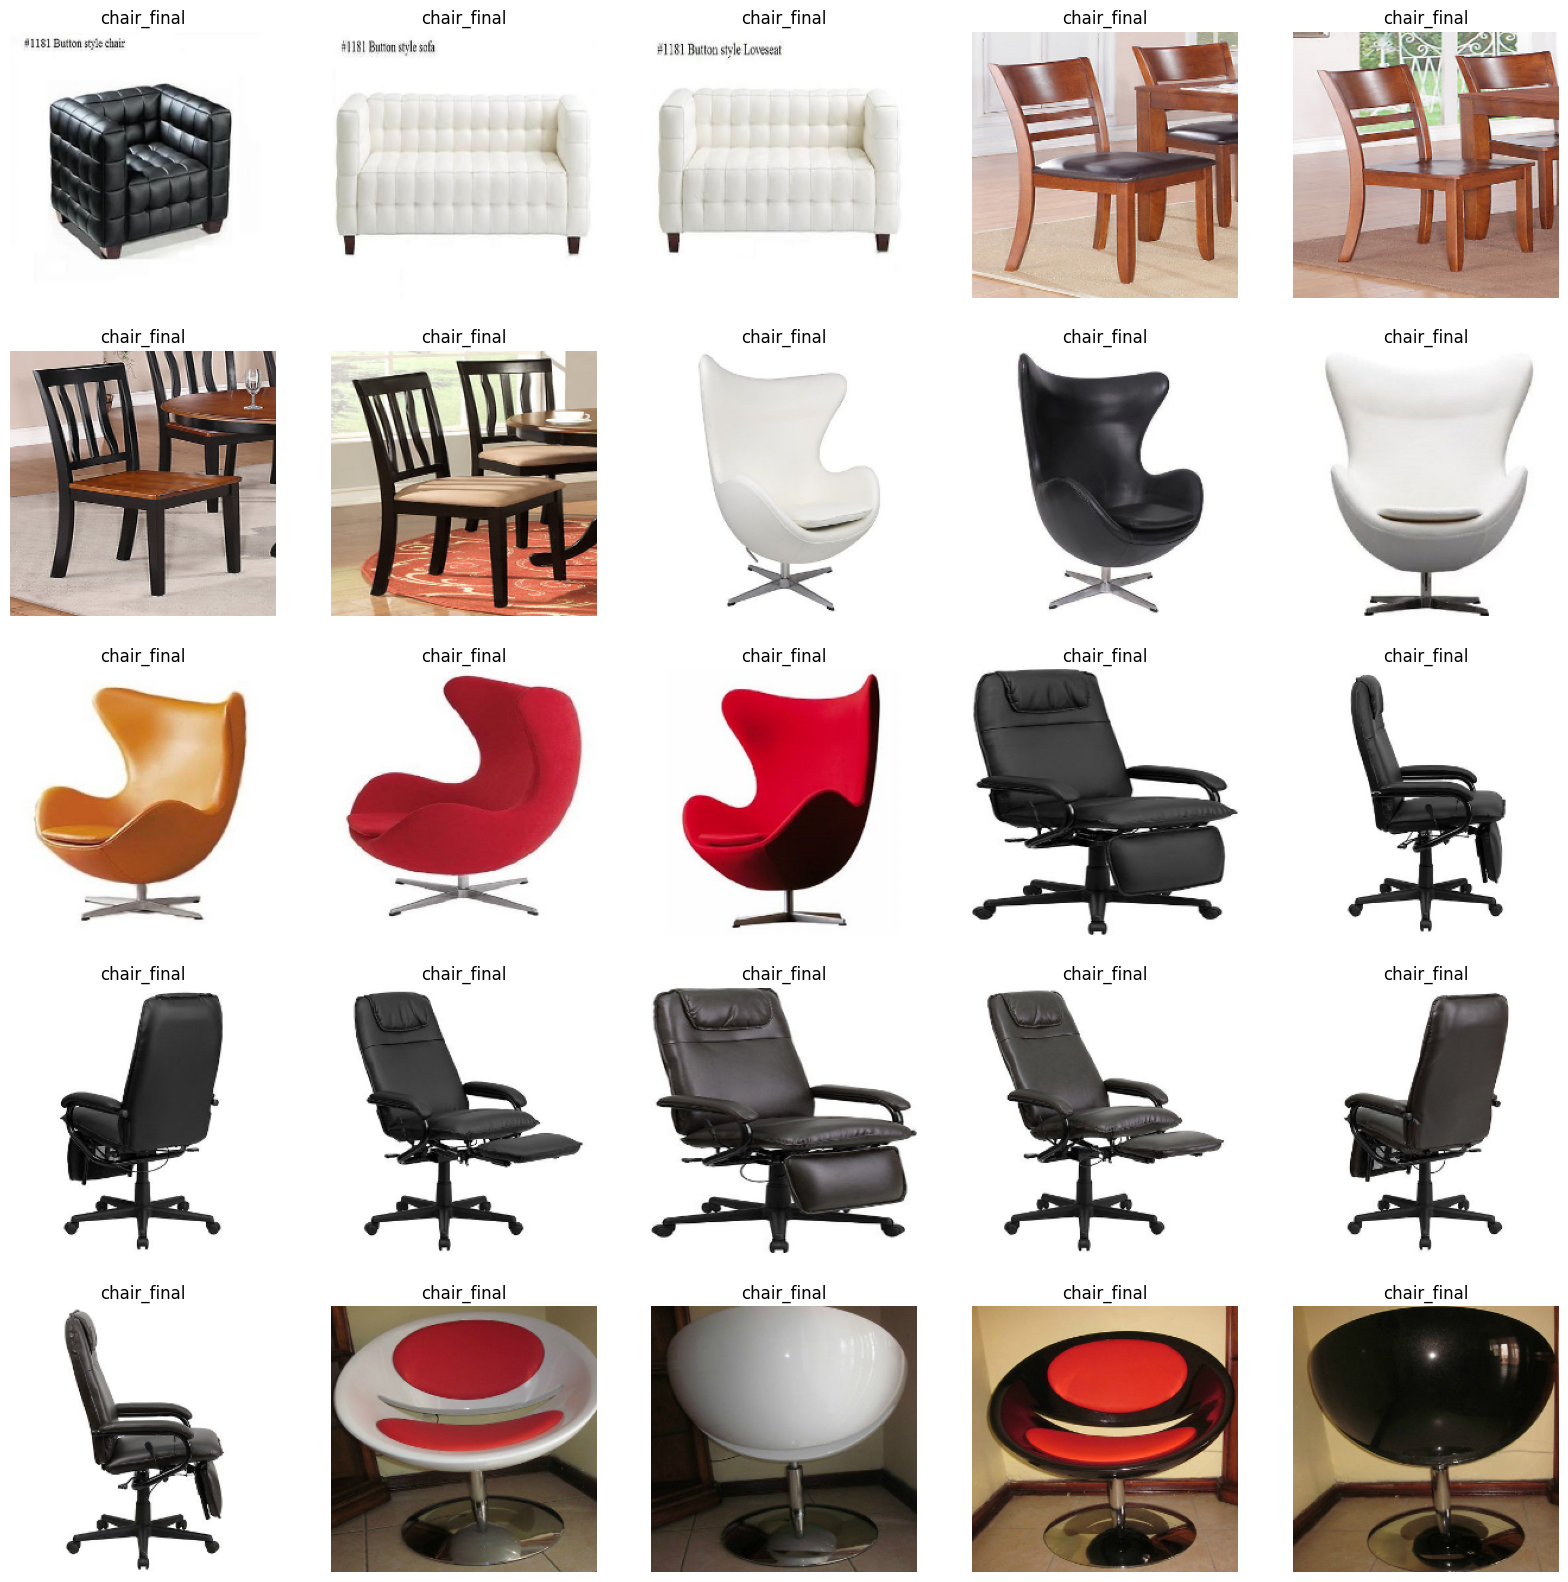

In [8]:
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(cv2.cvtColor(images[100+i], cv2.COLOR_BGR2RGB))
    plt.title(labels[100+i])
    plt.axis("off")

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time

pca = PCA(n_components=128, random_state=0)
train_reduced = pca.fit_transform(train)

start = time.time()
tsne = TSNE(n_components=3, random_state=0)
tsne_projections = tsne.fit_transform(train_reduced)
end = time.time()
print(f"Generating projections with T-SNE took: {(end - start):.2f} sec")

Generating projections with T-SNE took: 2.81 sec


In [20]:
def plot_3d_projections(projections, labels):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get unique labels and set up a colormap
    unique_labels = np.unique(labels)
    cmap = plt.get_cmap("viridis", len(unique_labels))
    
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax.scatter(projections[mask, 0],
                   projections[mask, 1],
                   projections[mask, 2],
                   label=label,
                   color=cmap(i),
                   s=50,
                   alpha=0.7)
    
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
    ax.legend(title="Labels")
    plt.show()

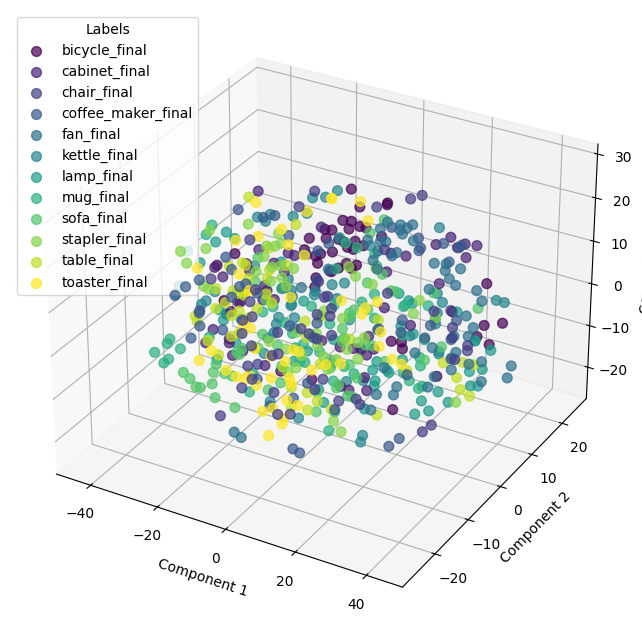

In [21]:
plot_3d_projections(tsne_projections, labels)

In [18]:
import umap
import time

start = time.time()
umap_projections = umap.UMAP(n_components=3).fit_transform(train)
end = time.time()
print(f"Generating projections with UMAP took: {(end-start):.2f} sec")

Generating projections with UMAP took: 7.42 sec


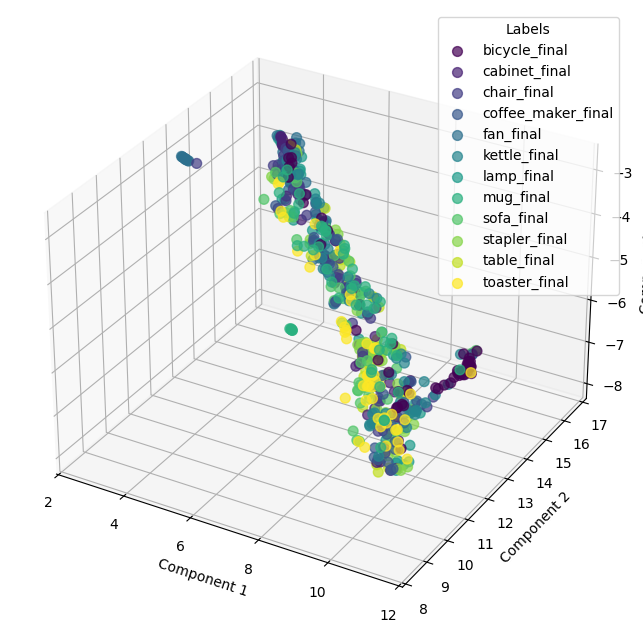

In [22]:
plot_3d_projections(umap_projections, labels)

In [ ]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

